# Hitter Analysis

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.graph_objs as go

### Set up dataframe

In [26]:
# import data 
df = pd.read_csv('savant_data_6_hitters.csv')

# clean df by eliminating rows where game_pk is empty
df.dropna(subset=['game_pk'], inplace=True)

# fix up column datatypes
df['game_pk'] = df['game_pk'].astype(int) # to get rid of the *.0
df['game_pk'] = df['game_pk'].astype(str)
df['sv_id'] = df['sv_id'].astype(str)
df['pitcher'] = df['pitcher'].astype(int) # to get rid of the *.0
df['batter'] = df['batter'].astype(int) # to get rid of the *.0

# eliminates rows where pitch_type is null
df = df[df['pitch_type'].notna()]

# create unique pitch_id
df['pitch_id'] = df['game_pk'] + " " + df['sv_id']

# find switch hitters
df['switch'] = np.where(df['batter'])

# show data 
#df.head()
#list(df.columns.values)
#df.isnull().sum()

In [27]:
# make new dataframe with less info
df_pitch_coords = df[['game_pk','sv_id','pitch_id','batter','stand','pitcher','pitch_type',
                      'release_speed','description','events','plate_x','plate_z']]

## TODO pass in top and bottom of strikezone for each batter 
# df_pitch_plate_coords = df[['plate_x','plate_z','sz_top','sz_bot']] 

## TODO switch coords to pitcher's perspective, currently in catcher's perspective

## TODO clean up by eliminating non-swing hits?

df_pitch_coords.head(10)

,game_pk,sv_id,pitch_id,batter,stand,pitcher,pitch_type,release_speed,description,events,plate_x,plate_z
0,566551,190929_195522,566551 190929_195522,641355,L,572125,FF,88.5,ball,walk,-1.0507,2.0102
1,566551,190929_195449,566551 190929_195449,641355,L,572125,SL,80.4,foul,NaN,-1.0378,2.2720
2,566551,190929_195427,566551 190929_195427,641355,L,572125,FF,87.5,ball,NaN,-0.6916,1.2693
3,566551,190929_195406,566551 190929_195406,641355,L,572125,SL,77.9,called_strike,NaN,0.3390,2.0581
4,566551,190929_195348,566551 190929_195348,641355,L,572125,FF,88.3,ball,NaN,-1.8748,1.3315
5,566551,190929_195329,566551 190929_195329,641355,L,572125,SL,79.5,ball,NaN,-1.1627,1.0541
6,565782,190929_200302,565782 190929_200302,593160,R,527048,CH,83.8,hit_into_play,field_out,0.9989,3.0047
7,567343,190929_195426,567343 190929_195426,641313,R,605513,SL,86.3,hit_into_play,field_out,0.4474,1.7602
8,565782,190929_192859,565782 190929_192859,593160,R,527048,FC,88.4,called_strike,strikeout,0.8837,3.1895
9,565782,190929_192841,565782 190929_192841,593160,R,527048,CH,85.3,ball,NaN,1.7583,2.8298


### Show all pitches in scatter plot 

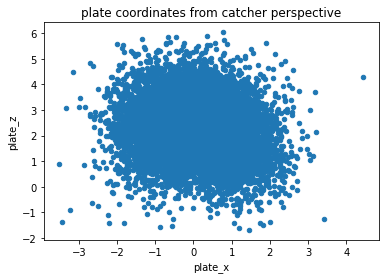

In [28]:
all_pitches_plot = df_pitch_coords.plot(kind='scatter', x='plate_x', y='plate_z',
                           title='plate coordinates from catcher perspective')
# center of plate at ground = (0,0)

all_pitches_plot

### Calculate what zone a pitch falls into

In [29]:
def det_zone(x,z):
    if (x < -1.5) or (x > 1.5) or (z < 1) or (z > 4):
        return 0 # outside of strike box, non-competitive pitches
    elif (1.5 <= z) and (z <= 3.5) and (-0.7 <= x) and (x <= 0.7):
        if (3.5 >= z) and (z > 2.83):
            if (x <= -0.23):
                return 1
            elif (x <= 0.23):
                return 2
            elif (x <= 0.7):
                  return 3
        elif (2.83 >= z) and (z > 2.17):
            if (x <= -0.23):
                return 4
            elif (x <= 0.23):
                return 5
            elif (x <= 0.7):
                return 6
        elif (2.17 >= z) and (z >= 1.5):
            if (x <= -0.23):
                return 7
            elif (x <= 0.23):
                return 8
            elif (x <= 0.7):
                return 9
    elif (3.5 < z) and (z <= 4) and (-1.5 <= x) and (x <= 1.5):
        if (x <= -0.7):
            return 10
        elif (x <= 0):
            return 11
        elif (x <= 0.7):
            return 12
        elif (x <= 1.5):
            return 13
    elif (2.5 < z) and (z <= 3.5):
        if (-1.5 <= x) and (-0.7 > x):
            return 14
        elif (0.7 < x) and (x <= 1.5):
            return 15
    elif (1.5 < z) and (z <= 2.5):
        if (-1.5 <= x) and (-0.7 > x):
            return 16
        elif (0.7 < x) and (x <= 1.5):
            return 17
    elif (1 <= z) and (z <= 1.5) and (-1.5 <= x) and (x <= 1.5):
        if (x <= -0.7):
            return 18
        elif (x <= 0):
            return 19
        elif (x <= 0.7):
            return 20
        elif (x <= 1.5):
            return 21
    return -1 # null or invalid 

### Measure success of pitch type per zone per batter 

In [40]:
# batters is dictionary that maps batter id to zones list
# zones is list that maps zone num (index) to pitch_types dictionary
# pitch_types is dictionary that maps type of pitch to counters for hits, fouls, strikes, and total pitches
batters = {}
for row in range(df_pitch_coords.shape[0]):
    pitch_zone = det_zone(df_pitch_coords.iloc[row]['plate_x'],
                        df_pitch_coords.iloc[row]['plate_z'])
  
    if (pitch_zone != -1): # don't include null or invalid pitches in zone -1
        batter_id = df_pitch_coords.iloc[row]['batter']
        pitch_type = df_pitch_coords.iloc[row]['pitch_type']
        pitch_events = df_pitch_coords.iloc[row]['events']
        pitch_result = df_pitch_coords.iloc[row]['description']
        pitch_speed = df_pitch_coords.iloc[row]['release_speed']

        # initialize new batter
        if batter_id not in batters:
            batters[batter_id] = [] # init empty zones list
            for z in range(22): # 22 zones (0: noncompetitive, 1-21: strikezone)
                pitch_types = {}
                batters[batter_id].insert(z, pitch_types)
        # initialize new pitch_type 
        if pitch_type not in batters[batter_id][pitch_zone]:
            batters[batter_id][pitch_zone][pitch_type] = [] #todo: maybe dict?
            for c in range(6): # num of counters
                batters[batter_id][pitch_zone][pitch_type].insert(c, 0)

        # Add to counters:
        
        # swing and miss
        if pitch_result in ('swinging_strike', 'swinging_strike_blocked'):
            batters[batter_id][pitch_zone][pitch_type][0] += 1
            batters[batter_id][pitch_zone][pitch_type][4] += 1 # total
            #batters[batter_id][pitch_zone][pitch_type][5] += pitch_speed
            #batters[batter_id][pitch_zone][pitch_type][5] /= total
        # swing and foul
        elif pitch_result in ('foul', 'foul_tip'): # foul (runner going) ???
            batters[batter_id][pitch_zone][pitch_type][1] += 1
            batters[batter_id][pitch_zone][pitch_type][4] += 1 # total
            #batters[batter_id][pitch_zone][pitch_type][5] += pitch_speed
            #batters[batter_id][pitch_zone][pitch_type][5] /= total
        # swing and hit
        elif pitch_result in ('hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'):
            # made contact and obtained a hit
            if pitch_events in ('single', 'double', 'triple', 'home_run'):
                batters[batter_id][pitch_zone][pitch_type][2] += 1
                batters[batter_id][pitch_zone][pitch_type][4] += 1 # total
                #batters[batter_id][pitch_zone][pitch_type][5] += pitch_speed
                #batters[batter_id][pitch_zone][pitch_type][5] /= total
            # made contact and obtained an out
            elif pitch_events not in ('single', 'double', 'triple', 'home_run'):
                batters[batter_id][pitch_zone][pitch_type][3] += 1
                batters[batter_id][pitch_zone][pitch_type][4] += 1 # total
                #batters[batter_id][pitch_zone][pitch_type][5] += pitch_speed
                #batters[batter_id][pitch_zone][pitch_type][5] /= total
        # else: # batter didn't swing

#print(batters)

In [31]:
for b in batters:
    for z in range(1,22): # dont include noncompetitive pitches in zone 0
        for p in batters[b][z]:
            num_misses = batters[b][z][p][0]
            num_fouls = batters[b][z][p][1]
            num_contact_to_hits = batters[b][z][p][2]
            num_contact_to_outs = batters[b][z][p][3]
            # total is sample size; when batter swings
            # batter not swinging isn't counted 
            total = batters[b][z][p][4]

            #total = num_misses + num_fouls + num_hits_to_outs + num_hits_to_hits
            #if total is 0:
            #  avg_speed = 0
            #else:
            #  avg_speed = batters[b][z][p][4] / total
        
            # TODO check formulas to see if make sense (esp ordering)
            # arbitrary numbers are user set; to adjust from default
            # Focus on the contact rather than result 
            # TODO set two or three preset defaults to sensitivity to contact 
            if total > 10:
                if (num_contact_to_hits / total) > 0.33:
                    batters[b][z][p].insert(5,"red")
                elif((num_fouls + num_misses) / total) > 0.8:
                    batters[b][z][p].insert(5,"green")
                elif((num_contact_to_outs + num_fouls + num_misses) / total) > 0.75:
                    batters[b][z][p].insert(5,"yellow")

#print(batters[641355])

### Sanity Check for colors of pitch types in zone for batter

In [32]:
def get_color(pitch_count_list):
    if len(pitch_count_list) > 5:
        color = pitch_count_list[5]
        return color

def get_speed(pitch_count_list):
    if len(pitch_count_list) > 5:
        speed = pitch_count_list[4]
        return speed

In [33]:
# for b in batters:
# b == 641355 -> Cody Bellinger
print("Cody Bellinger 2019 Season")
print()
for z in range(22):
    print("Zone %s" %z)
    red_pitch_types = []
    yellow_pitch_types = []
    green_pitch_types = []

    for p in batters[641355][z]:
        color = get_color(batters[641355][z][p])
        avg_speed = get_speed(batters[641355][z][p])
        if color == 'red':
            red_pitch_types.append((p, avg_speed))
        elif color == 'yellow':
            yellow_pitch_types.append((p, avg_speed))
        elif color == 'green':
            green_pitch_types.append((p, avg_speed))

    print("Red: " + str(red_pitch_types))
    print("Yellow: " + str(yellow_pitch_types))
    print("Green: " + str(green_pitch_types))
    print()

Cody Bellinger 2019 Season

Zone 0
Red: []
Yellow: []
Green: []

Zone 1
Red: []
Yellow: [('FF', 48)]
Green: []

Zone 2
Red: []
Yellow: [('FF', 58)]
Green: []

Zone 3
Red: []
Yellow: [('FF', 50)]
Green: []

Zone 4
Red: []
Yellow: [('FF', 49), ('CH', 23)]
Green: [('FT', 13)]

Zone 5
Red: []
Yellow: [('FT', 12), ('SI', 15)]
Green: []

Zone 6
Red: []
Yellow: [('SL', 14)]
Green: []

Zone 7
Red: []
Yellow: [('FF', 16), ('SL', 19), ('CH', 22)]
Green: []

Zone 8
Red: [('FF', 12)]
Yellow: [('SL', 13)]
Green: []

Zone 9
Red: []
Yellow: []
Green: []

Zone 10
Red: []
Yellow: []
Green: []

Zone 11
Red: []
Yellow: []
Green: [('FF', 31)]

Zone 12
Red: []
Yellow: [('FF', 25)]
Green: []

Zone 13
Red: []
Yellow: []
Green: []

Zone 14
Red: []
Yellow: [('FT', 12), ('SL', 11), ('FF', 36)]
Green: []

Zone 15
Red: []
Yellow: [('FF', 15)]
Green: []

Zone 16
Red: []
Yellow: [('FF', 17), ('SL', 16), ('CH', 36), ('FC', 11)]
Green: [('FT', 15)]

Zone 17
Red: []
Yellow: [('SI', 11)]
Green: []

Zone 18
Red: []
Yell